<a href="https://colab.research.google.com/github/Prabodh-gaikar/py/blob/main/Braintumor(91).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 20 kB/s 


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2

In [ ]:
data = '/content/drive/MyDrive/Colab Notebooks/data1/brain_tumor_dataset'
No_brain_tumor = '/content/drive/MyDrive/Colab Notebooks/data1/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/drive/MyDrive/Colab Notebooks/data1/brain_tumor_dataset/yes'

In [ ]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  3149    labels:  3149


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)

df.head()

,filepaths,labels
0,/content/drive/MyDrive/Colab Notebooks/data1/b...,No
1,/content/drive/MyDrive/Colab Notebooks/data1/b...,No
2,/content/drive/MyDrive/Colab Notebooks/data1/b...,No
3,/content/drive/MyDrive/Colab Notebooks/data1/b...,No
4,/content/drive/MyDrive/Colab Notebooks/data1/b...,No


In [ ]:
print(df['labels'].value_counts())

Yes    2261
No      888
Name: labels, dtype: int64


In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (2691, 2)
test set shape: (158, 2)
validation set shape: (300, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 2691 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [ ]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)  
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 25, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/25
169/169 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.6997

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


169/169 [==============================] - 537s 3s/step - loss: 0.5925 - accuracy: 0.6997 - val_loss: 0.4879 - val_accuracy: 0.7933
Epoch 2/25
169/169 [==============================] - 450s 3s/step - loss: 0.4651 - accuracy: 0.7874 - val_loss: 0.4306 - val_accuracy: 0.7967
Epoch 3/25
169/169 [==============================] - 447s 3s/step - loss: 0.4082 - accuracy: 0.8239 - val_loss: 0.3896 - val_accuracy: 0.8500
Epoch 4/25
169/169 [==============================] - 448s 3s/step - loss: 0.3759 - accuracy: 0.8439 - val_loss: 0.3639 - val_accuracy: 0.8467
Epoch 5/25
169/169 [==============================] - 445s 3s/step - loss: 0.3322 - accuracy: 0.8632 - val_loss: 0.3666 - val_accuracy: 0.8433
Epoch 6/25
169/169 [==============================] - 445s 3s/step - loss: 0.3171 - accuracy: 0.8685 - val_loss: 0.3296 - val_accuracy: 0.8533
Epoch 7/25
169/169 [==============================] - 449s 3s/step - loss: 0.3019 - accuracy: 0.8789 - val_loss: 0.3104 - val_accuracy: 0.8900
Epoch 8/25

In [ ]:
model.save("/content/Tumor_classifier_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


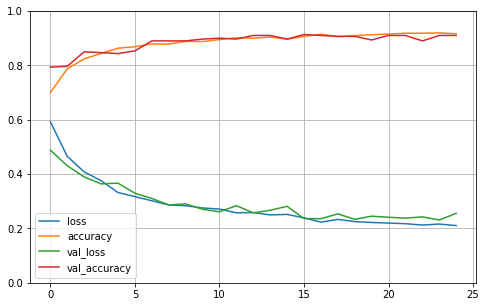

In [ ]:
# Evaluating the model

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Checking our model

from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import numpy as np

image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data1/brain_tumor_dataset/yes/Y1.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >=0.5:
  print("Yes")
else:
  print("No")  

Yes


In [ ]:
pred

array([[0.9236196]], dtype=float32)

In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}